**Import Semua Packages/Library yang Digunakan**

In [3]:
pip install tensorflow tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.5 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [52]:
import numpy as np
import os
from PIL import Image
import pandas as pd
import zipfile
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K


from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    BatchNormalization,
    Flatten,
    Dense,
    Activation,
    Dropout,
)

# Model
from tensorflow.keras.models import Sequential

# Optimizer
from tensorflow.keras.optimizers import Adam

# Callbacks
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau,
)

from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import TFSMLayer  # Import TFSMLayer

**Data Preparation**

In [7]:
zip_file_path = '/content/archive (1).zip'

# Direktori tujuan untuk mengekstrak file
extract_to_dir = 'archive (1)'

# Mengekstrak file zip
try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to_dir)
    print(f"File {zip_file_path} berhasil diekstrak ke {extract_to_dir}")
except zipfile.BadZipFile:
    print(f"Error: File {zip_file_path} is not a valid zip file or is corrupted.")
    print("Please check the file integrity and download a fresh copy if necessary.")
except FileNotFoundError:
    print(f"Error: File {zip_file_path} not found. Please check the file path.")

File /content/archive (1).zip berhasil diekstrak ke archive (1)


In [8]:
# Verify if the directory exists
sdir = "/content/archive (1)/garbage_classification"  # Added a space after archive
if os.path.exists(sdir):
    print(f"Directory '{sdir}' exists.")
else:
    print(f"Directory '{sdir}' does not exist. Please check the path and extraction process.")


# Inisialisasi list untuk menyimpan path file dan label kelas
filepaths = []
labels = []

# Ambil daftar kelas dari direktori sumber data
classlist = os.listdir(sdir)

Directory '/content/archive (1)/garbage_classification' exists.


In [9]:
# Loop melalui setiap kelas untuk mengumpulkan file gambar dan labelnya
for klass in classlist:
    classpath = os.path.join(sdir, klass)  # Buat path lengkap ke folder kelas

    if os.path.isdir(classpath):  # Cek apakah path tersebut adalah direktori
        flist = os.listdir(classpath)  # Ambil daftar file dalam folder kelas

        for f in flist:
            fpath = os.path.join(classpath, f)  # Buat path lengkap ke file gambar

            filepaths.append(fpath)
            labels.append(klass)

In [10]:
# Membuat DataFrame
df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})

**Data Loading**

In [11]:
# Inisialisasi list untuk menyimpan ukuran gambar
widths = []
heights = []

# Loop melalui setiap file gambar
for filepath in df['filepaths']:
    with Image.open(filepath) as img:
        width, height = img.size
        widths.append(width)
        heights.append(height)

# Tambahkan kolom 'width' dan 'height' ke DataFrame
df['width'] = widths
df['height'] = heights

# Cek DataFrame
print(df.head())

                                           filepaths labels  width  height
0  /content/archive (1)/garbage_classification/me...  metal    512     384
1  /content/archive (1)/garbage_classification/me...  metal    259     194
2  /content/archive (1)/garbage_classification/me...  metal    276     183
3  /content/archive (1)/garbage_classification/me...  metal    225     225
4  /content/archive (1)/garbage_classification/me...  metal    512     384


In [12]:
# Hitung frekuensi pasangan lebar x tinggi
size_distribution = df.groupby(['width', 'height']).size().reset_index(name='count')

# Urutkan berdasarkan jumlah gambar (opsional)
size_distribution = size_distribution.sort_values(by='count', ascending=False)

# Tampilkan hasil
print(size_distribution)

     width  height  count
609    400     533   2590
824    512     384   2358
245    225     225   2004
610    400     534   1077
359    275     183    691
..     ...     ...    ...
879    741     400      1
878    726     400      1
873    709     400      1
872    708     400      1
871    705     400      1

[892 rows x 3 columns]


<ipython-input-13-ca18ec13448e>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='size', y='count', data=top_sizes, palette='magma')


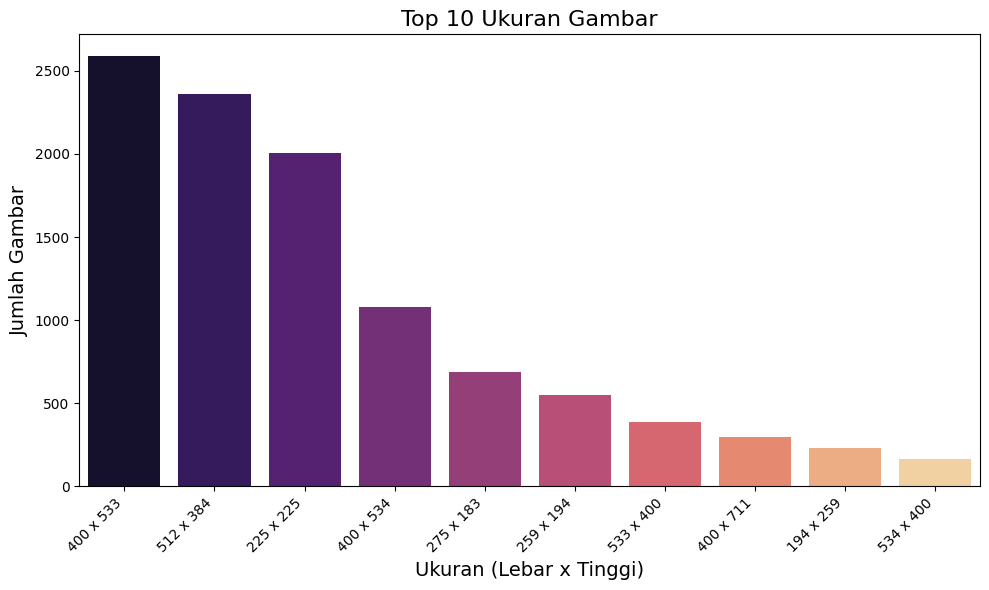

In [13]:
# Ambil 10 pasangan ukuran terbanyak untuk visualisasi
top_sizes = size_distribution.head(10).copy()  # Gunakan .copy() untuk menghindari SettingWithCopyWarning

# Gabungkan lebar dan tinggi menjadi satu label
top_sizes['size'] = top_sizes['width'].astype(str) + ' x ' + top_sizes['height'].astype(str)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='size', y='count', data=top_sizes, palette='magma')
plt.title('Top 10 Ukuran Gambar', fontsize=16)
plt.xlabel('Ukuran (Lebar x Tinggi)', fontsize=14)
plt.ylabel('Jumlah Gambar', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()  # Menghindari potongan label pada sumbu x
plt.show()

In [24]:
# Hitung jumlah sampel setiap kelas
class_counts = df['labels'].value_counts()

# Tampilkan jumlah data per kelas
print("Jumlah data per kelas:")
print(class_counts)

# Hitung total jumlah data
total_data = len(df)

# Tampilkan total jumlah data
print(f"\nTotal jumlah data: {total_data}")

Jumlah data per kelas:
labels
clothes        5325
shoes          1977
paper          1050
biological      985
battery         945
cardboard       891
plastic         865
white-glass     775
metal           769
trash           697
green-glass     629
brown-glass     607
Name: count, dtype: int64

Total jumlah data: 15515


#### Split Dataset

In [14]:
train_split=.8
test_split=.1
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  12412   test_df length:  1551   valid_df length:  1552


In [15]:
height=224
width=224
channels=3
batch_size=64

img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

gen=ImageDataGenerator(
    rescale=1./255,
    )
train_gen=gen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

validgen=ImageDataGenerator(rescale=1./255)
valid_gen=validgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

testgen=ImageDataGenerator(rescale=1./255)
test_gen=testgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)

classes=list(train_gen.class_indices.keys())
print (classes)
class_count=len(classes)

test batch size:  47   test steps:  33
Found 12412 validated image filenames belonging to 12 classes.
Found 1552 validated image filenames belonging to 12 classes.
Found 1551 validated image filenames belonging to 12 classes.
['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


In [16]:
def show_image_samples(gen):
    test_dict=test_gen.class_indices
    classes=list(test_dict.keys())
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

**Modelling**

In [17]:
# Load base model Xception tanpa top layer
base_model = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_tensor=Input(shape=(224, 224, 3))
)

base_model.summary()

# Freeze base model agar bobotnya tidak berubah saat training awal
base_model.trainable = False

model_name = 'xception'
print("Building model with", base_model)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 111, 111,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 111, 111,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 109, 109,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 109, 109,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 109, 109,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 109, 109,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 109, 109,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 109, 109,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 109, 109,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 109, 109,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 55, 55,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 55, 55,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 55, 55,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 55, 55,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 55, 55,    │          0 │ add[0][0]       

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

Building model with <Functional name=xception, built=True>


In [19]:
# Bangun model Sequential dengan tambahan layer custom di atas base model
model = tf.keras.Sequential([
    base_model,
    Conv2D(filters=32, kernel_size=3, strides=1,
           padding='same', activation='relu'),
    MaxPooling2D(pool_size=2, strides=2), # Change MaxPool2D to MaxPooling2D
    Dropout(rate=0.5),

    Flatten(),
    Dense(12, activation='softmax')  # Sesuaikan jumlah kelas output (12)
])

# Compile model dengan optimizer Adam dan loss categorical_crossentropy untuk klasifikasi multi-kelas
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [21]:
# Custom Callback: Hentikan training jika akurasi > 95%

class MyCallback(Callback):

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        acc = logs.get('accuracy')
        if acc is not None and acc > 0.95:
            print(f"\nTraining accuracy reached {acc*100:.2f}%, stopping training.")
            self.model.stop_training = True

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
   verbose=1,
   min_delta=0.01,
   mode='max'
)

model_checkpoint = ModelCheckpoint(
   filepath='best_model.keras',
   monitor='val_accuracy',
   save_best_only=True,
   verbose=1,
   mode='max'
)

reduce_lr = ReduceLROnPlateau(
   monitor='val_loss',
   factor=0.2,
   patience=5,
   min_lr=1e-6,
   verbose=1
)

callbacks_list = [early_stopping, model_checkpoint , reduce_lr , MyCallback()]

epochs = 20

history=model.fit(
     x=train_gen ,
     epochs=epochs ,
     validation_data=(valid_gen) ,
     callbacks=[*callbacks_list]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.6186 - loss: 1.2342 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)



Epoch 1: val_accuracy improved from -inf to 0.85889, saving model to best_model.keras
194/194 ━━━━━━━━━━━━━━━━━━━━ 3657s 19s/step - accuracy: 0.6192 - loss: 1.2321 - val_accuracy: 0.8589 - val_loss: 0.4243 - learning_rate: 0.0010
Epoch 2/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.8764 - loss: 0.4048 
Epoch 2: val_accuracy improved from 0.85889 to 0.91430, saving model to best_model.keras
194/194 ━━━━━━━━━━━━━━━━━━━━ 3563s 18s/step - accuracy: 0.8765 - loss: 0.4047 - val_accuracy: 0.9143 - val_loss: 0.2999 - learning_rate: 0.0010
Epoch 3/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.9220 - loss: 0.2597 
Epoch 3: val_accuracy improved from 0.91430 to 0.91753, saving model to best_model.keras
194/194 ━━━━━━━━━━━━━━━━━━━━ 3588s 19s/step - accuracy: 0.9219 - loss: 0.2598 - val_accuracy: 0.9175 - val_loss: 0.2817 - learning_rate: 0.0010
Epoch 4/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.9330 - loss: 0.2041 
Epoch 4: val_accuracy did not improve from

**Visualisasi Akurasi dan Loss Training & Validation**

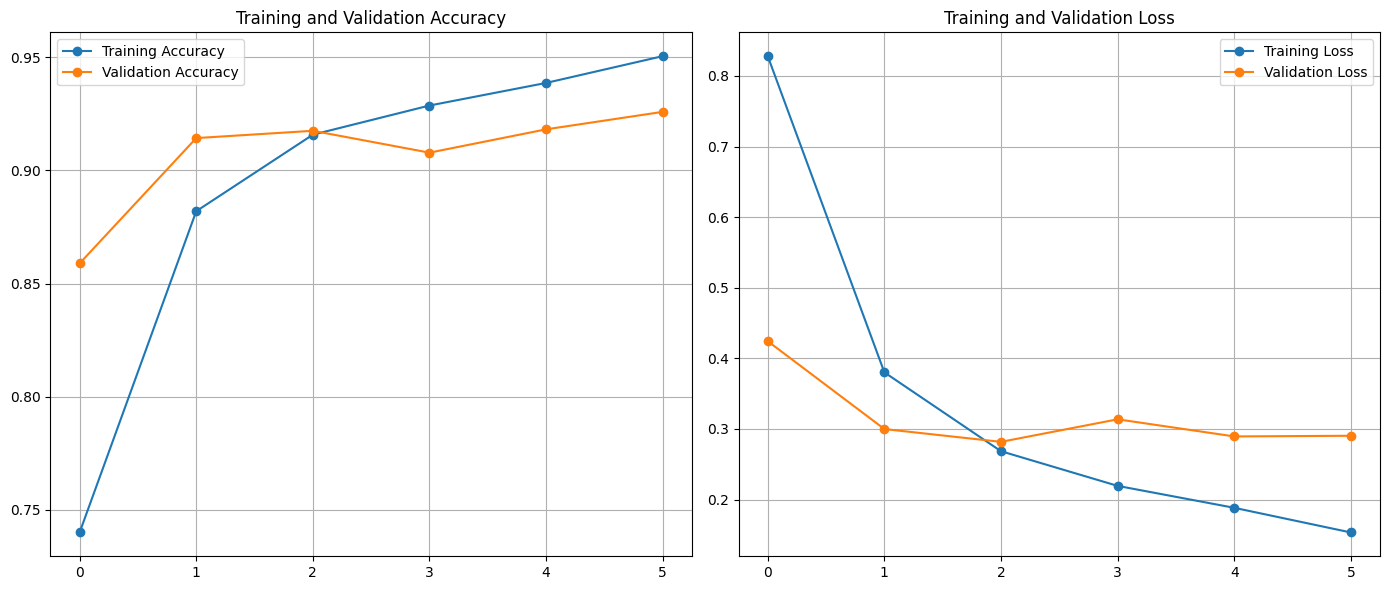

In [22]:
# Ekstrak nilai akurasi dan loss dari history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))  # jumlah epoch yang sudah dijalankan

# Membuat plot
plt.figure(figsize=(14, 6))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


**Evaluasi**

25/25 ━━━━━━━━━━━━━━━━━━━━ 399s 16s/step

📝 Classification Report:
              precision    recall  f1-score   support

     battery       0.01      0.01      0.01        86
  biological       0.05      0.06      0.06       104
 brown-glass       0.00      0.00      0.00        73
   cardboard       0.06      0.06      0.06        87
     clothes       0.35      0.35      0.35       533
 green-glass       0.03      0.03      0.03        65
       metal       0.07      0.07      0.07        69
       paper       0.06      0.06      0.06       114
     plastic       0.02      0.03      0.03        72
       shoes       0.17      0.16      0.17       194
       trash       0.01      0.01      0.01        67
 white-glass       0.05      0.06      0.06        88

    accuracy                           0.16      1552
   macro avg       0.07      0.08      0.08      1552
weighted avg       0.16      0.16      0.16      1552



<Figure size 1000x800 with 0 Axes>

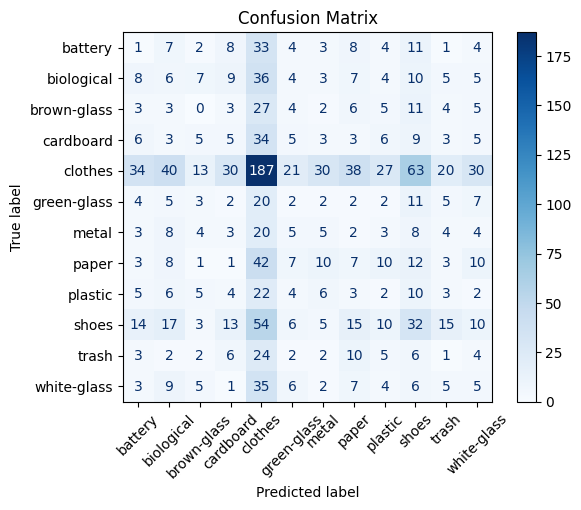

In [27]:
# Prediksi probabilitas
y_pred_probs = model.predict(valid_gen, verbose=1)

# Ambil kelas prediksi
y_pred = np.argmax(y_pred_probs, axis=1)

# Ambil kelas sebenarnya
y_true = valid_gen.classes

# Ambil nama-nama kelas
class_names = list(valid_gen.class_indices.keys())

# --- Classification Report ---
print("\n📝 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

## Konversi Model

In [36]:
# Membuat folder untuk SavedModel
saved_model_dir = 'saved_model'  # Direktori untuk SavedModel
os.makedirs(saved_model_dir, exist_ok=True)

tf.saved_model.save(model, saved_model_dir)  # Save as a SavedModel

print(f"Model berhasil disimpan di folder: {saved_model_dir}")

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


Model berhasil disimpan di folder: saved_model


In [37]:
# Membuat folder untuk TFLite
tflite_dir = 'tflite'
os.makedirs(tflite_dir, exist_ok=True)

# Konversi model ke format TFLite
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)  # Baca dari direktori SavedModel
tflite_model = converter.convert()

# Simpan model TFLite
tflite_model_path = os.path.join(tflite_dir, 'model.tflite')
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"Model berhasil dikonversi dan disimpan ke {tflite_model_path}")

# (Opsional) Menyimpan label ke label.txt
labels_path = os.path.join(tflite_dir, 'label.txt')
with open(labels_path, 'w') as f:
    for label in class_names:
        f.write(label + '\n')

print(f"Label file berhasil disimpan di {labels_path}")

Model berhasil dikonversi dan disimpan ke tflite/model.tflite
Label file berhasil disimpan di tflite/label.txt


In [39]:
# Membuat folder untuk TFJS
tfjs_dir = 'tfjs_model'

# Konversi ke format TFJS
!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model {saved_model_dir} {tfjs_dir}

print(f" Model berhasil dikonversi ke TensorFlow.js format di folder: {tfjs_dir}")


2025-04-18 04:28:35.561936: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744950515.616090   98364 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744950515.630440   98364 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-04-18 04:28:55.467614: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
I0000 00:00:1744950539.706007   98364 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00

## Inference (Optional)

Predicted Label: plastic


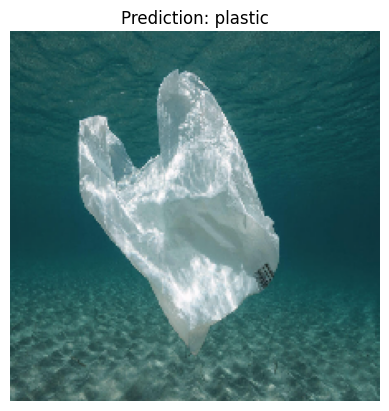

In [53]:
# Load the SavedModel as an inference-only layer
loaded_model = TFSMLayer('saved_model', call_endpoint='serving_default')

# Path to the image for inference
# **Make sure this path is correct and the image exists**
image_path = 'Screenshot 2025-04-18 115727.png'  # Replace with your image path or make sure the image is in the current directory

# Image preprocessing
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

# Perform prediction using the TFSMLayer
# Wrap the input in a tf.Tensor
input_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
predictions = loaded_model(input_tensor) # Call the TFSMLayer like a function

# Access the output tensor from the predictions dictionary
output_tensor = predictions['output_0']

# Get the predicted class and label
predicted_class = np.argmax(output_tensor, axis=1)[0]
class_names = list(valid_gen.class_indices.keys())  # Assuming valid_gen is accessible
predicted_label = class_names[predicted_class]

# Display prediction results
print(f"Predicted Label: {predicted_label}")
plt.imshow(img)
plt.title(f"Prediction: {predicted_label}")
plt.axis('off')
plt.show()